In [2]:
import scipy.io
import pandas as pd
import numpy as np
import itertools
from ci_test import ci_test
import pickle
import cdt
import networkx as nx
import matplotlib.pyplot as plt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [19]:
datasets = []

for dataset_i in range(1,5):
    d_mat = scipy.io.loadmat(f"D{dataset_i}.mat")
    datasets.append(np.array(pd.DataFrame(d_mat['D'])))

## 1.1 SGS Algorithm

In [4]:
def sgs(dataset: np.ndarray) -> (np.ndarray, [set]):
    n_columns = dataset.shape[1]
    all_nodes = range(n_columns)

    adjacency_matrix =  np.zeros((n_columns, n_columns))

    # Initialize a list of sets to keep for the edge orientation phase
    #Z_set = np.full((n_columns, n_columns), set())
    Z_set = [[set() for i in range(n_columns)] for j in range(n_columns)]

    for node_i in all_nodes:
        nodes = list(all_nodes)
        nodes.remove(node_i)
        # Pick a different 2nd variable
        for node_j in nodes:
            possible_controls = list(all_nodes).copy()
            possible_controls.remove(node_i)
            possible_controls.remove(node_j)
            for n_controls in range(len(possible_controls)):
                condition_set = list(itertools.combinations(possible_controls, n_controls))

                conditionnal_indep_does_not_hold = True
                for condition in condition_set:
                    if ci_test(dataset, node_i, node_j, condition):
                        conditionnal_indep_does_not_hold = False
                        break
                if conditionnal_indep_does_not_hold:
                    adjacency_matrix[node_i][node_j] = adjacency_matrix[node_j][node_i] = 1
                    Z_set[node_i][node_j] |= set(condition_set)
                    Z_set[node_i][node_j] |= set(condition_set)

    return adjacency_matrix, Z_set

## 1.1 PC Algorithm

In [5]:
def pc1(dataset: np.ndarray) -> (np.ndarray, [set]):
    n_columns = dataset.shape[1]
    all_nodes = range(n_columns)

    # Initialize a fully connected adjency matrix (no self connection since its a DAG)
    adjacency_matrix = np.ones((n_columns, n_columns)) - np.identity(n_columns)

    Z_set = [[set() for i in range(n_columns)] for j in range(n_columns)]
    # Pick the 1st variable
    for node_i in all_nodes:
        nodes = list(all_nodes)
        nodes.remove(node_i)
        # Pick a different 2nd variable
        for node_j in nodes:
            # Pick a condition set
            for n_controls in all_nodes:
                possible_controls = list(all_nodes)
                possible_controls.remove(node_i)
                possible_controls.remove(node_j)


                for condition_set in list(itertools.combinations(possible_controls, n_controls)):
                    if ci_test(dataset, node_i, node_j, condition_set):
                        adjacency_matrix[node_i][node_j] =  adjacency_matrix[node_j][node_i] = 0

                        Z_set[node_i][node_j] |= set(condition_set)
                        Z_set[node_j][node_i] |= set(condition_set)

    return adjacency_matrix, Z_set

1.2 Modified PC algorithm

In [6]:
def pc2(dataset: np.ndarray) -> (np.ndarray, [set]):
    n_columns = dataset.shape[1]
    all_nodes = range(n_columns)

    adjacency_matrix =  np.zeros((n_columns, n_columns))
    Z_set = [[set() for i in range(n_columns)] for j in range(n_columns)]

    for node_i in all_nodes:
        nodes = list(all_nodes)
        nodes.remove(node_i)
        # Pick a different 2nd variable
        for node_j in nodes:
            # Pick a condition set
            for n_controls in all_nodes:
                possible_controls = list(all_nodes)
                possible_controls.remove(node_i)
                possible_controls.remove(node_j)

                if not ci_test(dataset, node_i, node_j, possible_controls):
                    adjacency_matrix[node_i][node_j] = 1

                for condition in itertools.combinations(possible_controls, n_controls):
                    if ci_test(dataset, node_i, node_j, condition):
                        adjacency_matrix[node_i][node_j] = 0

                        Z_set[node_i][node_j] |= set(condition)
                        Z_set[node_j][node_i] |= set(condition)
                        break


    return adjacency_matrix, Z_set


## 2 Orienting the edges
### 2.1 Starting with V-structures

In [7]:
for (i,j,k) in itertools.combinations([1,2,3,4,5], 3):
    print(i,j,k)

1 2 3
1 2 4
1 2 5
1 3 4
1 3 5
1 4 5
2 3 4
2 3 5
2 4 5
3 4 5


In [12]:
def add_v_structures(graph: nx.Graph, Z_sets: [set]) -> nx.DiGraph:
    directed_graph = nx.DiGraph(graph)
    nodes = range(len(graph.nodes))

    for i in nodes :
        nodes_j = list(nodes)
        nodes_j.remove(i)
        for j in nodes_j:
            nodes_k = list(nodes_j)
            nodes_k.remove(j)
            for k in nodes_k:
                if directed_graph.has_edge(i,j) and directed_graph.has_edge(j,k) and (not directed_graph.has_edge(i,k)):
                    if j not in Z_sets[i][k]:
                        if directed_graph.has_edge(i,j):
                            directed_graph.remove_edge(i,j)
                        if directed_graph.has_edge(k,j):
                            directed_graph.remove_edge(k,j)
    return directed_graph

## 2.2 Adding the two meek rules

In [13]:
def add_meek_rules(directed_graph: nx.DiGraph) -> nx.DiGraph:
    directed_graph = nx.DiGraph(graph)
    nodes = range(len(graph.nodes))
    for i in nodes :
        nodes_j = list(nodes)
        nodes_j.remove(i)
        for j in nodes_j:
            nodes_k = list(nodes_j)
            nodes_k.remove(j)

        # meek 1
        if directed_graph.has_edge(i, j) & directed_graph.has_edge(j, i):
            to_remove = set()
            for parent in directed_graph.predecessors(i):
                if directed_graph.has_edge(i, parent) or (directed_graph.has_edge(parent, j) or directed_graph.has_edge(node_j, parent)):
                    continue
                else:
                   to_remove.add((node_j,node_i))

            for pair in to_remove:
                directed_graph.remove_edge(*pair)


        # meek 2
        if directed_graph.has_edge(node_i, node_j) & directed_graph.has_edge(node_j, node_i):
            for child in directed_graph.successors(node_i):
                if (not directed_graph.has_edge(child, node_i)) and directed_graph.has_edge(child, node_j):
                    directed_graph.remove_edge(node_j, node_i)

    return  directed_graph

In [27]:
sgs_directed_graphs = []

for dataset in datasets[:3]:
    adjacency_mat, condition_set = sgs(dataset)
    graph = nx.from_numpy_matrix(adjacency_mat)

    directed_graph = add_v_structures(graph, condition_set)
    sgs_directed_graphs.append(add_meek_rules(directed_graph))

In [29]:
pc1_directed_graphs = []

for dataset in datasets[:3]:
    adjacency_mat, condition_set = pc1(dataset)
    graph = nx.from_numpy_matrix(adjacency_mat)

    directed_graph = add_v_structures(graph, condition_set)
    pc1_directed_graphs.append(add_meek_rules(directed_graph))

In [30]:
pc2_directed_graphs = []

for dataset in datasets[:3]:
    adjacency_mat, condition_set = pc2(dataset)
    graph = nx.from_numpy_matrix(adjacency_mat)

    directed_graph = add_v_structures(graph, condition_set)
    pc2_directed_graphs.append(add_meek_rules(directed_graph))

In [23]:
# For heavier matrix
adjacency_mat, condition_set = pc2(datasets[3])
graph = nx.from_numpy_matrix(adjacency_mat)

directed_graph = add_v_structures(graph, condition_set)
pc2_directed_graphs.append(add_meek_rules(directed_graph))

KeyboardInterrupt: 

## 3. Results
## 3.1 SGS Graphs

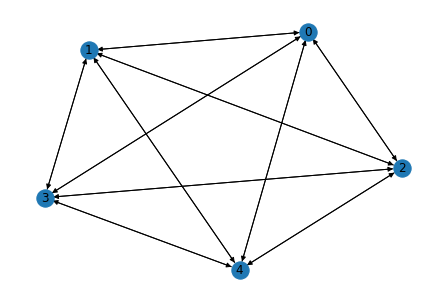

In [24]:
nx.draw(sgs_directed_graphs[0], with_labels=True)

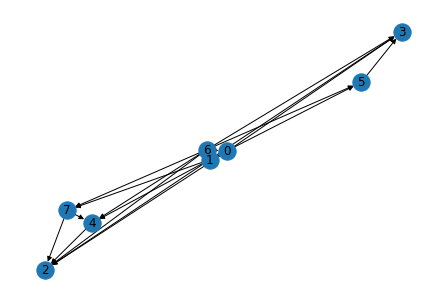

In [25]:
nx.draw(sgs_directed_graphs[1], with_labels=True)

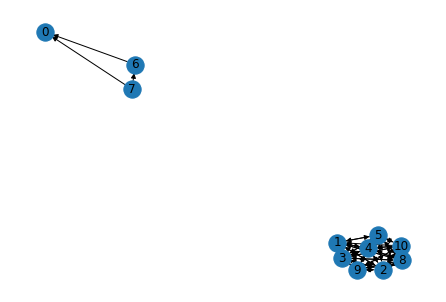

In [31]:
nx.draw(sgs_directed_graphs[2], with_labels=True)

## 3.2 PC1 Graphs

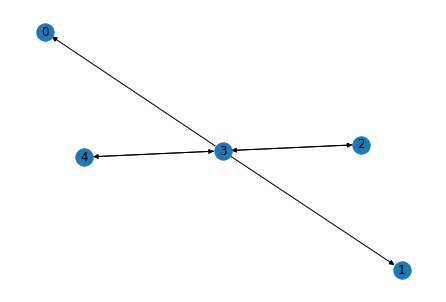

In [35]:
nx.draw(pc1_directed_graphs[0], with_labels=True)

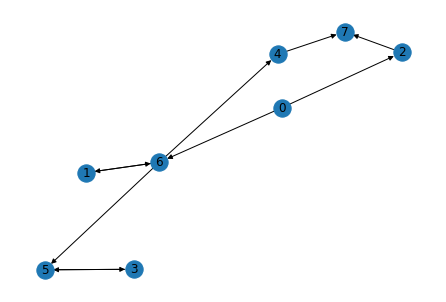

In [36]:
nx.draw(pc1_directed_graphs[1], with_labels=True)

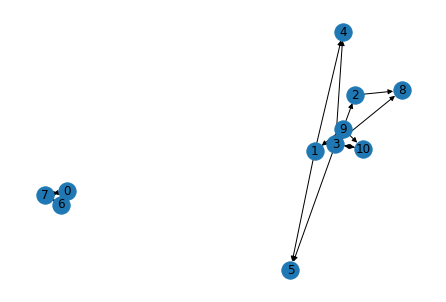

In [37]:
nx.draw(pc1_directed_graphs[2], with_labels=True)

## 3.2 PC2 Graphs

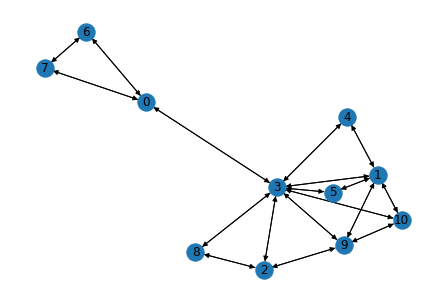

In [38]:
nx.draw(pc2_directed_graphs[2], with_labels=True)

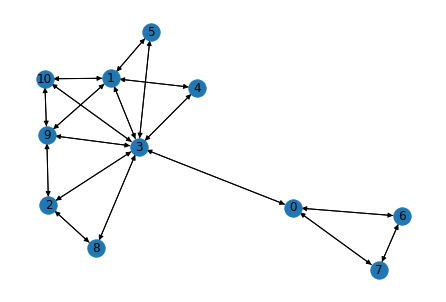

In [39]:
nx.draw(pc2_directed_graphs[2], with_labels=True)

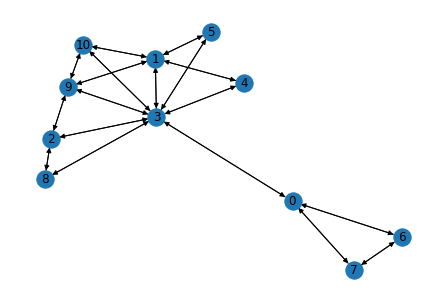

In [40]:
nx.draw(pc2_directed_graphs[2], with_labels=True)